# AlexNet with PyTorch🔥

AlexNet is very first example of how powerfull Deep Neural Networks are.<br>
Released in 2012 paper proved that neural networks, given enough depth, can work insanely good & outperform traditional ML algorithms.<br>

# Part I.  Quick Overview & Goal Setting.

The image you see below is the graph of overall network architecture. This graph is pretty accurate, although original paper has input of 224x224x3<br>
It's nothing crazy these days, but back then, 5 convolutional layers with THIS MANY kernels was insane.<br>
<img src="https://www.researchgate.net/publication/329790469/figure/fig2/AS:705721712787456@1545268576139/Simplified-illustration-of-the-AlexNet-architecture.ppm" width=100%><br>
Since Architecture is quite old there are a few remarks to do about model and about data:<br>

## No GPU kernels distribution.
I see no point in using 2 GPUs and distributing computations on both devices.<br>
First of all, it's pain in the @ss, Secondly, it's just unnecessary.<br>
Since then a significant improvement on the chips market happened, so now 1 P100 GPU will be enough. However, there are more points to why I don't use 2 GPUs, one of which is:<br>

## Data.
Original AlexNet was trained on the ImageNet subset with 1000 classes.<br>
I think I should better find some middleground. 1000 classes is excessively ambigious for proof of concept, while 10 classes is too easy and boring.<br>
In this notebook I will use CIFAR-100 dataset as it shares the idea of originall ImageNet dataset (multiclass object classification on the RGB image) and it's simple to use.<br>
Original CIFAR100 has size of 32x32 and this is boring & far from original ImageNet problem, so I use upscaled dataset with 128x128 images, I think it's okay!

### The rest is pretty good, so let's go!

## Part II. Data Loading.

In [94]:
!pip install torchinfo
!pip install torchmetrics

In [95]:
# Imporing necessary modules

import torch
from torch import nn
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

from torchinfo import summary
from torchmetrics import Accuracy
from torch.utils.tensorboard import SummaryWriter

from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

In [96]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [97]:
# Not ideal, but I tried my best to replicate data augmentation from the paper
data_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [98]:
root_dir = Path("/kaggle/input/cifar100-128x128-resized-via-cai-super-resolution/cifar100-128")
train_dir = root_dir / "train"
test_dir = root_dir / "test"

In [99]:
train_dataset = ImageFolder(root=train_dir,
                           transform=data_transform,
                           target_transform=None)
test_dataset = ImageFolder(root=test_dir,
                          transform=data_transform,
                          target_transform=None)

In [100]:
train_dataset, test_dataset

(Dataset ImageFolder
     Number of datapoints: 49951
     Root location: /kaggle/input/cifar100-128x128-resized-via-cai-super-resolution/cifar100-128/train
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                RandomCrop(size=(224, 224), padding=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 10000
     Root location: /kaggle/input/cifar100-128x128-resized-via-cai-super-resolution/cifar100-128/test
     StandardTransform
 Transform: Compose(
                Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
                RandomCrop(size=(224, 224), padding=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [101]:
print(f"Cifar goes {len(train_dataset.classes)}!")

Cifar goes 100!


In [103]:
train_dataloader = DataLoader(train_dataset,
                              batch_size=64,
                              shuffle=True,
                              num_workers=os.cpu_count(),
                              pin_memory=True)
test_dataloader = DataLoader(test_dataset,
                             batch_size=64,
                             shuffle=False,
                             num_workers=os.cpu_count(),
                             pin_memory=True)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7bd89817b8e0>,
 <torch.utils.data.dataloader.DataLoader at 0x7bd89817ae30>)

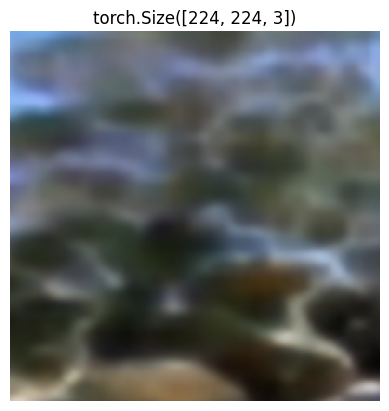

In [104]:
for image_batch, label_batch in train_dataloader:
    sample = image_batch[2].permute(1, 2, 0)
    plt.axis("off")
    plt.title(sample.shape)
    plt.imshow(sample);
    break

Dang, images are all blurry, but fine, it decreases human level performance baseline XD

## Part III. Model
Nothing crazy here, just the clou of this entire notebook!

In [149]:
class AlexNetV0(nn.Module):
    def __init__(self):
        super().__init__()
        # Formula for calculating output shape: [(W−K+2P)/S]+1
        self.conv_block = nn.Sequential(
            # 1st layer - in: (224, 224, 3) - out: (27, 27, 96)
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=(11, 11), stride=4, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            # 2nd layer - in: (27, 27, 96) - out: (13, 13, 256)
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=(5, 5), padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            # 3rd layer - in: (13, 13, 256) - out: (13, 13, 384)
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            # 4th layer - in: (13, 13, 384) - out: (13, 13, 384)
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            # 5th layer - in: (13, 13, 384) - out: (6, 6, 256)
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=(3, 3), padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(3, 3), stride=2),
            nn.Flatten()
        )

        self.dense_block = nn.Sequential(
            nn.Dropout(p=0.5),
            # 6th layer - in: 43264, out - 4096
            nn.Linear(in_features=6*6*256, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            # 7th layer - in: 4096, out-4096
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            # 8th layer - in 4096, out-100
            nn.Linear(in_features=4096, out_features=100)
        )

    def forward(self, x):
       return self.dense_block(self.conv_block(x))

In [150]:
alex_net = AlexNetV0().to(device)
summary(alex_net, input_size=(64, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNetV0                                [64, 100]                 --
├─Sequential: 1-1                        [64, 9216]                --
│    └─Conv2d: 2-1                       [64, 96, 55, 55]          34,944
│    └─ReLU: 2-2                         [64, 96, 55, 55]          --
│    └─MaxPool2d: 2-3                    [64, 96, 27, 27]          --
│    └─Conv2d: 2-4                       [64, 256, 27, 27]         614,656
│    └─ReLU: 2-5                         [64, 256, 27, 27]         --
│    └─MaxPool2d: 2-6                    [64, 256, 13, 13]         --
│    └─Conv2d: 2-7                       [64, 384, 13, 13]         885,120
│    └─ReLU: 2-8                         [64, 384, 13, 13]         --
│    └─Conv2d: 2-9                       [64, 384, 13, 13]         1,327,488
│    └─ReLU: 2-10                        [64, 384, 13, 13]         --
│    └─Conv2d: 2-11                      [64, 256, 13, 13]      

We Are Close to the original number of parameters of AlexNet (58,691,044).<br>
It's as cool as bad (I have a bad premonition), because having +- the same model we have 10x less classes and 20x less samples in training dataloader.
I think we will need to tune model for our needs, but let's see what we get with original one!

## PART IV. Training

In [119]:
def train_step(model: nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device):
    accuracy_fn = Accuracy("multiclass", num_classes=100).to(device)
    running_loss, running_acc = 0, 0

    model.train()
    
    for image_batch, label_batch in dataloader:
        image_batch = image_batch.to(device)
        label_batch = label_batch.to(device)

        logits = model(image_batch)
        activated_pred = torch.softmax(logits, dim=1).argmax(dim=1)

        batch_accuracy = accuracy_fn(activated_pred, label_batch)
        batch_loss = loss_fn(logits, label_batch)
        running_loss += batch_loss
        running_acc += batch_accuracy

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

    running_loss /= len(dataloader)
    running_acc /= len(dataloader)

    return running_loss, running_acc


def test_step(model: nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: nn.Module,
              device: torch.device):
    accuracy_fn = Accuracy("multiclass", num_classes=100).to(device)
    running_loss, running_acc = 0, 0

    model.eval()
    
    with torch.inference_mode():
        for image_batch, label_batch in dataloader:
            image_batch = image_batch.to(device)
            label_batch = label_batch.to(device)
    
            logits = model(image_batch)
            activated_pred = torch.softmax(logits, dim=1).argmax(dim=1)
    
            batch_accuracy = accuracy_fn(activated_pred, label_batch)
            batch_loss = loss_fn(logits, label_batch)
            running_loss += batch_loss
            running_acc += batch_accuracy
    
        running_loss /= len(dataloader)
        running_acc /= len(dataloader)
    return running_loss, running_acc

In [120]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=alex_net.parameters(), momentum=0.9, weight_decay=0.0005, lr=0.01)

In [121]:
EPOCHS = 20
torch.manual_seed(42)
torch.cuda.manual_seed(42)


results = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": []
}

writer = SummaryWriter()

for epoch in range(EPOCHS):
    train_loss, train_acc = train_step(alex_net, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(alex_net, test_dataloader, loss_fn, device)

    print(f"EPOCH: {epoch} | "
          f"tr_loss: {train_loss} | tr_acc: {train_acc}"
          f"ts_loss: {test_loss} | ts_acc: {test_acc}"
         )

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    writer.add_scalar('Loss/train', train_loss, epoch)
    writer.add_scalar('Loss/test', test_loss, epoch)
    writer.add_scalar('Accuracy/train', train_acc, epoch)
    writer.add_scalar('Accuracy/test', test_acc, epoch)

EPOCH: 0 | tr_loss: 4.604637622833252 | tr_acc: 0.009423015639185905ts_loss: 4.591765880584717 | ts_acc: 0.014729299582540989
EPOCH: 1 | tr_loss: 4.399058818817139 | tr_acc: 0.030012184754014015ts_loss: 4.140354156494141 | ts_acc: 0.05165207013487816
EPOCH: 2 | tr_loss: 4.013365745544434 | tr_acc: 0.07662710547447205ts_loss: 3.783047676086426 | ts_acc: 0.10897691547870636
EPOCH: 3 | tr_loss: 3.644961357116699 | tr_acc: 0.13246884942054749ts_loss: 3.421584367752075 | ts_acc: 0.1759554147720337
EPOCH: 4 | tr_loss: 3.31408429145813 | tr_acc: 0.19222667813301086ts_loss: 3.1485908031463623 | ts_acc: 0.2280055731534958
EPOCH: 5 | tr_loss: 3.0473599433898926 | tr_acc: 0.2427079975605011ts_loss: 2.833444356918335 | ts_acc: 0.2896098792552948
EPOCH: 6 | tr_loss: 2.7977094650268555 | tr_acc: 0.2918075919151306ts_loss: 2.6225268840789795 | ts_acc: 0.3300159275531769
EPOCH: 7 | tr_loss: 2.5739681720733643 | tr_acc: 0.33950281143188477ts_loss: 2.441352128982544 | ts_acc: 0.3709195852279663
EPOCH: 8

In [123]:
torch.save(alex_net.state_dict(), "/kaggle/working/first_try.pth")

In [127]:
# Oh shit... Great! Kaggle doesn't render tensorboard(
%load_ext tensorboard
%tensorboard --logdir runs

<IPython.core.display.Javascript object>

## I think it's okay. I'm tired btw)
Maybe I can tune it to perform better (of course I can, but dude...)